In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, cross_validate, train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load the features data and preprocess
parrot = pd.read_csv('seychelles_features.csv',index_col=0)
parrot # check the dataframe
# subset the data frame according to the site of collection
vdm_data = parrot[parrot['site'] == 'vdm']
gn_data = parrot[parrot['site'] == 'gn']
fp1_data = parrot[parrot['site'] == 'fp1']
fp2_data = parrot[parrot['site'] == 'fp2']

# Assuming your data is already loaded into the variables gn_data, fp1_data, fp2_data, vdm_data
sites_data = {
    'gn': gn_data,
    'fp1': fp1_data,
    'fp2': fp2_data,
    'vdm': vdm_data
}

# Combine all data
all_data = pd.concat([gn_data, fp1_data, fp2_data, vdm_data])

In [4]:
# Define Evaluation Functions
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(8, 8))
    ConfusionMatrixDisplay(cm).plot(xticks_rotation="vertical", values_format=".0%", ax=ax)
    plt.title(title)
    plt.show()

    

def evaluate_model(train_sites, test_site):
    # Prepare training and testing data
    train_data = pd.concat([sites_data[site] for site in train_sites])
    test_data = sites_data[test_site]

    X_train = train_data.drop(['annotation_id', 'path', 'parrot', 'start_time', 'end_time', 'site'], axis=1)
    y_train = train_data['parrot']

    X_test = test_data.drop(['annotation_id', 'path', 'parrot', 'start_time', 'end_time', 'site'], axis=1)
    y_test = test_data['parrot']

    # Apply PCA
    n_components = 0.95  # This means PCA will retain 95% of the variance
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    results = {}


    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
    rf_model.fit(X_train_pca, y_train)

    y_train_pred_rf = rf_model.predict(X_train_pca)
    y_test_pred_rf = rf_model.predict(X_test_pca)

    precision_train_rf = precision_score(y_train, y_train_pred_rf)
    precision_test_rf = precision_score(y_test, y_test_pred_rf)
    print(f"RandomForest Training Precision: {precision_train_rf}, Test Precision: {precision_test_rf}")

    results['RandomForest'] = {
        'precision_train': precision_train_rf,
        'precision_test': precision_test_rf,
        'classification_report_train': classification_report(y_train, y_train_pred_rf, output_dict=True),
        'classification_report_test': classification_report(y_test, y_test_pred_rf, output_dict=True)
    }

    plot_confusion_matrix(y_train, y_train_pred_rf, "RandomForest Training Confusion Matrix")
    plot_confusion_matrix(y_test, y_test_pred_rf, "RandomForest Test Confusion Matrix")


    # Logistic Regression
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train_pca, y_train)

    y_train_pred_lr = lr_model.predict(X_train_pca)
    y_test_pred_lr = lr_model.predict(X_test_pca)

    precision_train_lr = precision_score(y_train, y_train_pred_lr)
    precision_test_lr = precision_score(y_test, y_test_pred_lr)
    print(f"LogisticRegression Training Precision: {precision_train_lr}, Test Precision: {precision_test_lr}")

    results['LogisticRegression'] = {
        'precision_train': precision_train_lr,
        'precision_test': precision_test_lr,
        'classification_report_train': classification_report(y_train, y_train_pred_lr, output_dict=True),
        'classification_report_test': classification_report(y_test, y_test_pred_lr, output_dict=True)
    }

    plot_confusion_matrix(y_train, y_train_pred_lr, "LogisticRegression Training Confusion Matrix")
    plot_confusion_matrix(y_test, y_test_pred_lr, "LogisticRegression Test Confusion Matrix")

    return results


RandomForest Training Precision: 1.0, Test Precision: 0.9


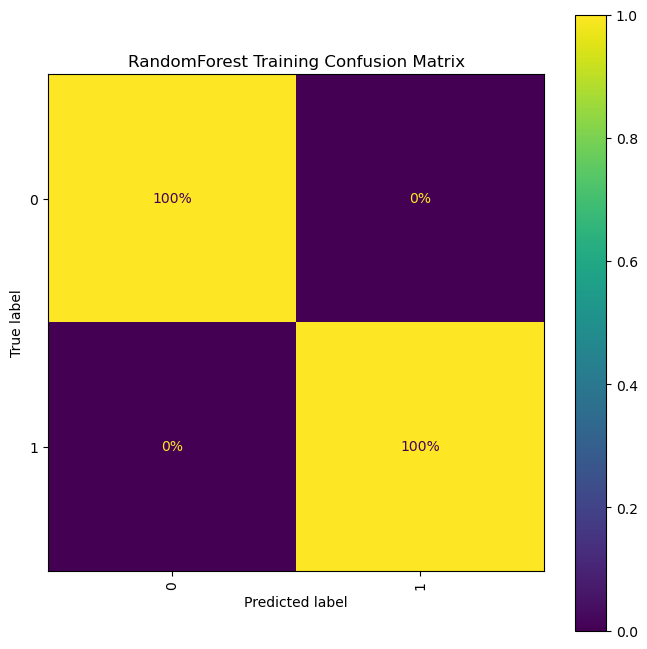

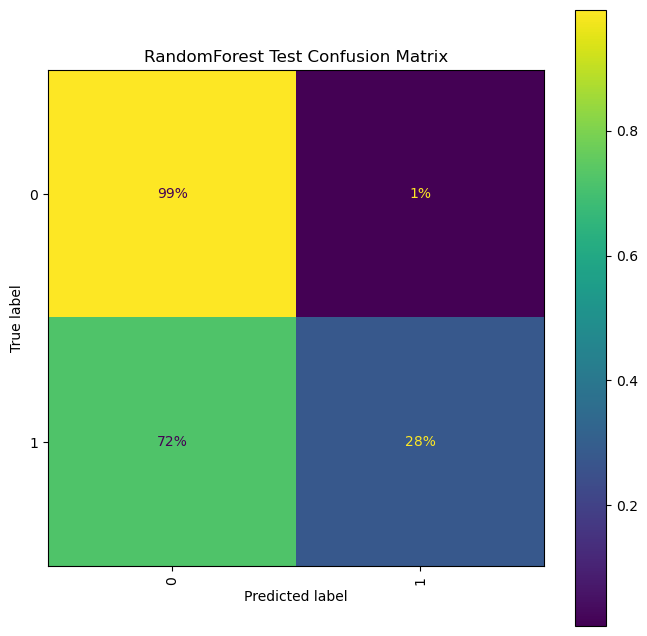

LogisticRegression Training Precision: 0.9344262295081968, Test Precision: 0.7894736842105263


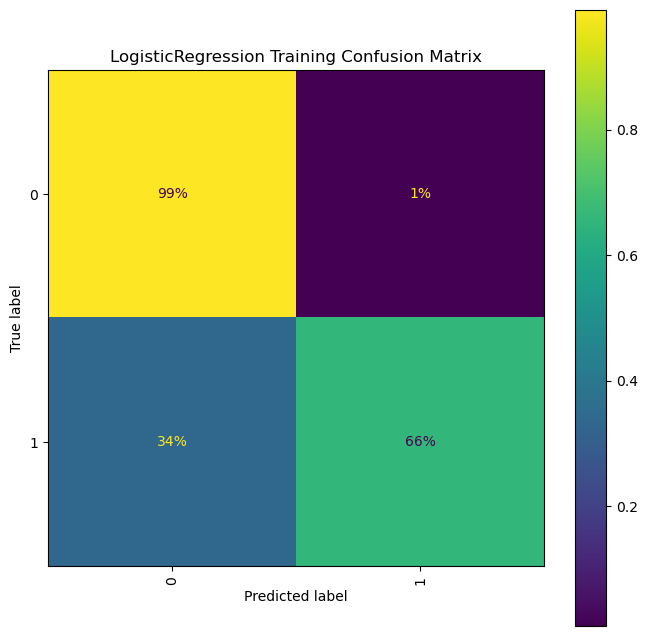

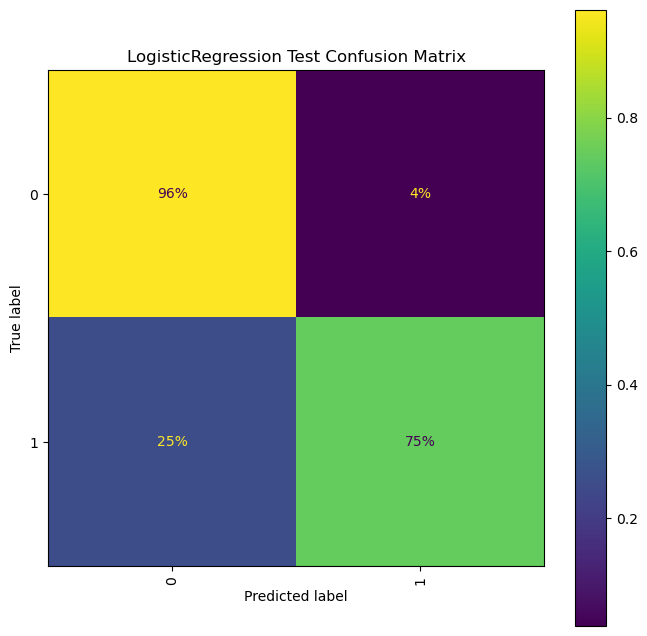

RandomForest Training Precision: 1.0, Test Precision: 0.96


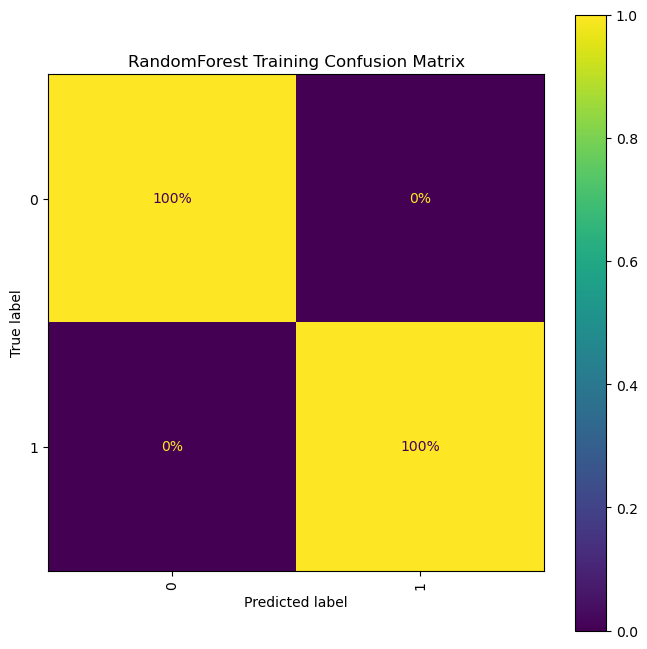

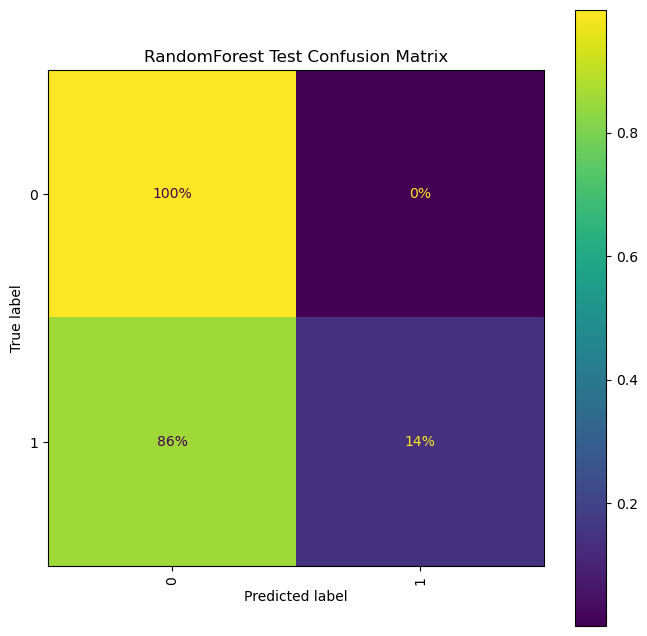

LogisticRegression Training Precision: 0.9414634146341463, Test Precision: 0.9404761904761905


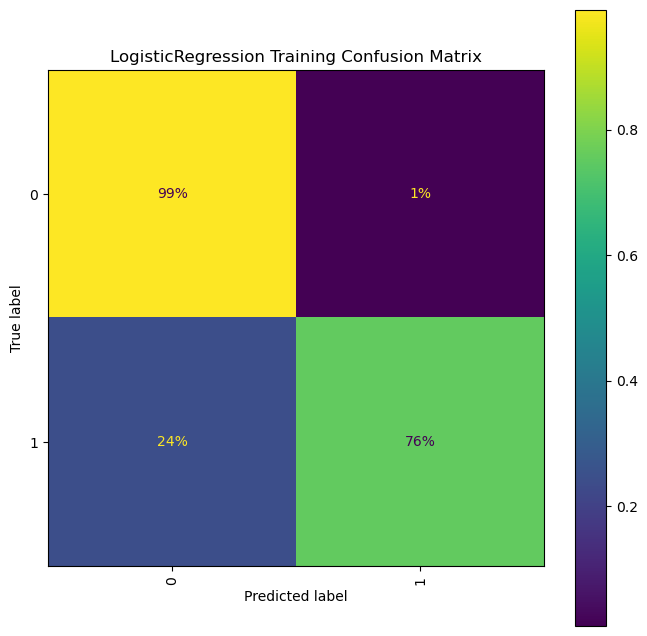

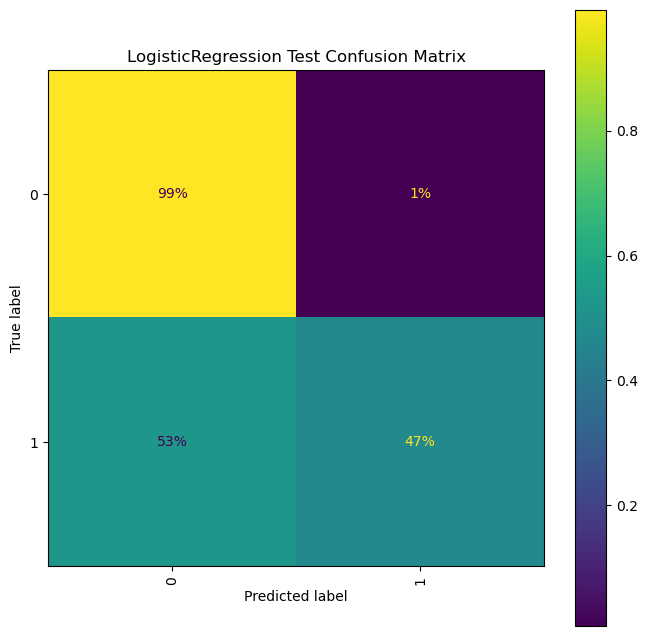

RandomForest Training Precision: 1.0, Test Precision: 0.8888888888888888


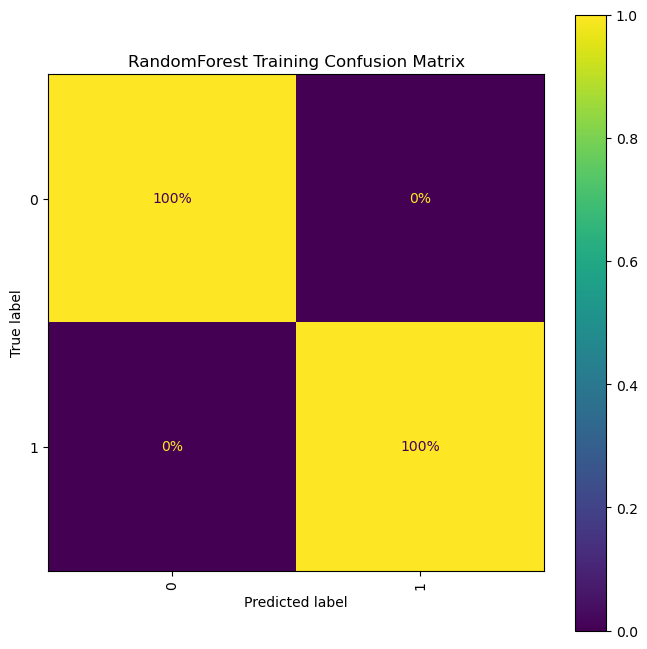

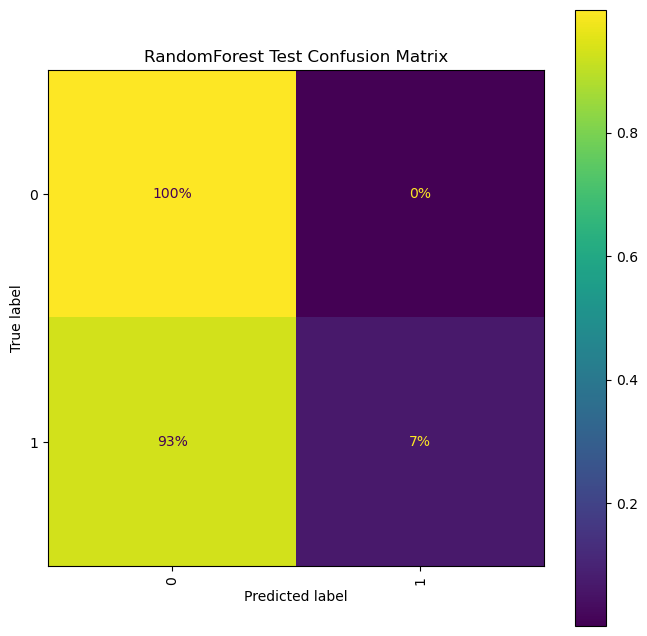

LogisticRegression Training Precision: 0.9189814814814815, Test Precision: 0.7415730337078652


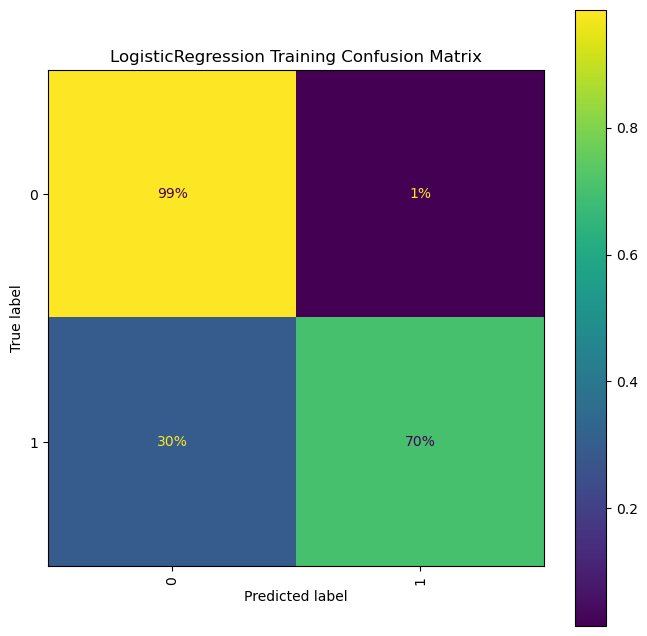

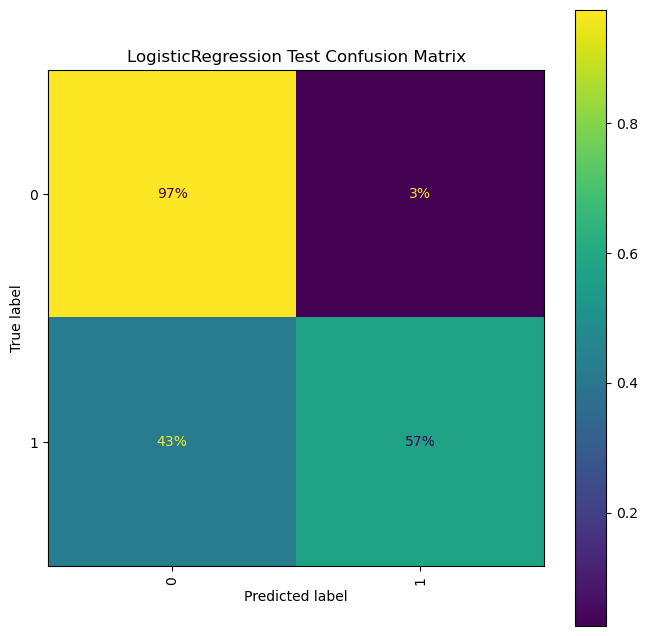

RandomForest Training Precision: 1.0, Test Precision: 0.6759259259259259


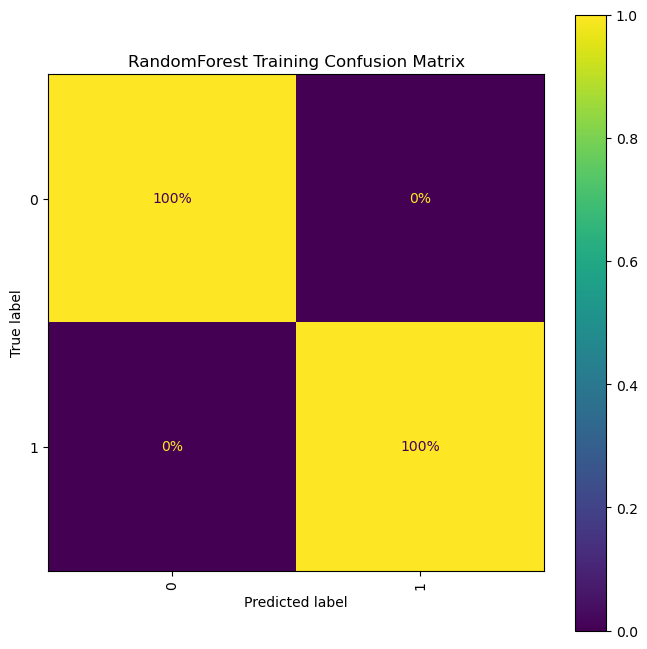

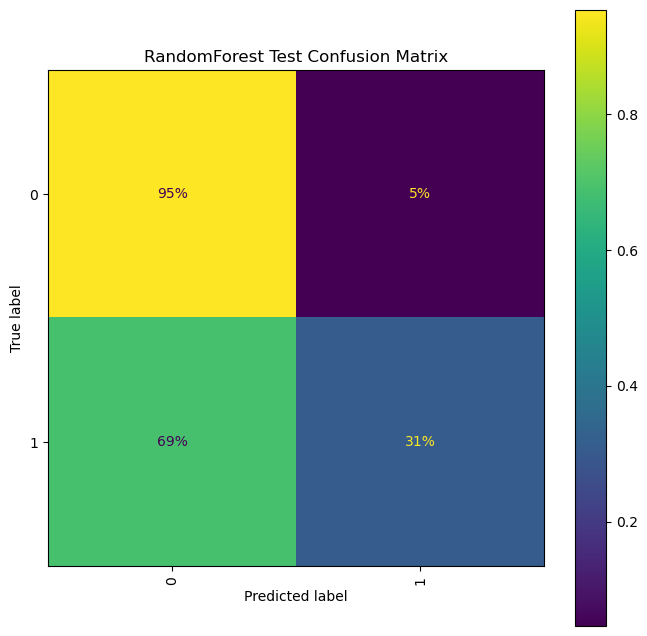

LogisticRegression Training Precision: 0.939297124600639, Test Precision: 0.7897727272727273


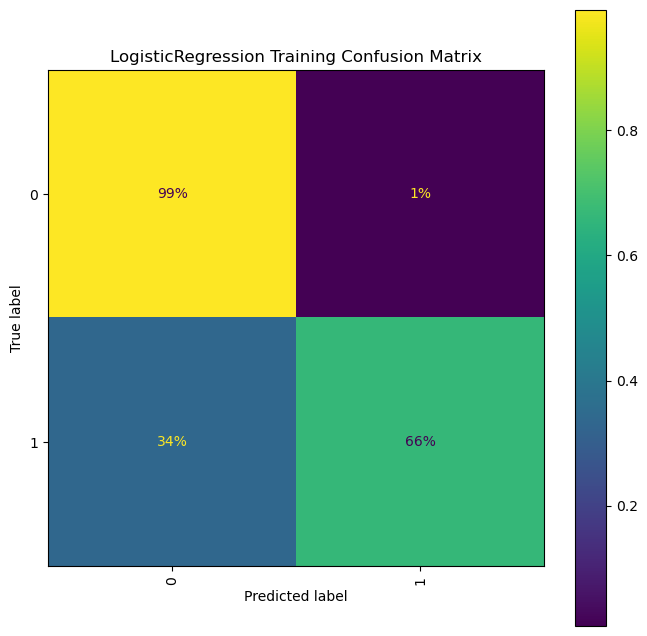

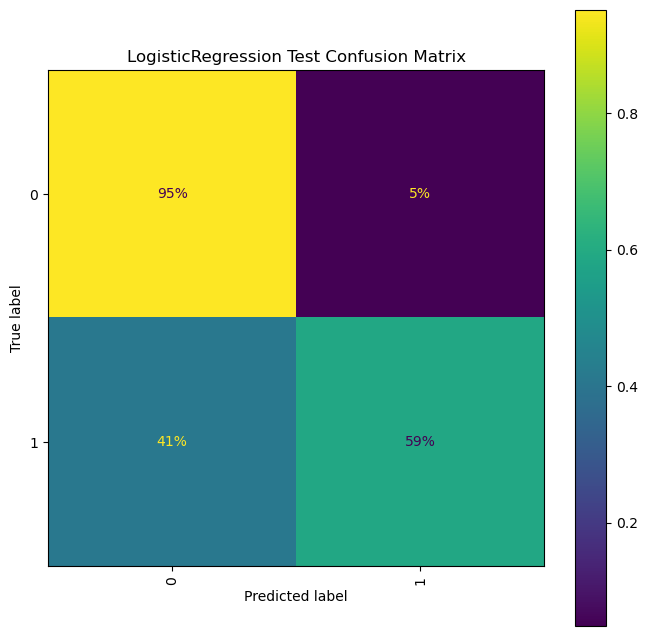

Train Sites: ['fp1', 'fp2', 'vdm'], Test Site: gn
Model: RandomForest
Training Precision: 1.0, Test Precision: 0.9
Training Classification Report:
               precision  recall  f1-score  support
False               1.0     1.0       1.0   2466.0
True                1.0     1.0       1.0    518.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   2984.0
weighted avg        1.0     1.0       1.0   2984.0
Test Classification Report:
               precision    recall  f1-score   support
False          0.877895  0.994041  0.932364   839.000
True           0.900000  0.279503  0.426540   161.000
accuracy       0.879000  0.879000  0.879000     0.879
macro avg      0.888947  0.636772  0.679452  1000.000
weighted avg   0.881454  0.879000  0.850927  1000.000
Model: LogisticRegression
Training Precision: 0.9344262295081968, Test Precision: 0.7894736842105263
Training Classification Report:
               precision    recall  f1-score      support
Fa

In [6]:
# Iterate over all sites
all_sites = ['gn', 'fp1', 'fp2', 'vdm']
results = []

for test_site in all_sites:
    train_sites = [site for site in all_sites if site != test_site]
    result = evaluate_model(train_sites, test_site)
    results.append({
        'train_sites': train_sites,
        'test_site': test_site,
        'results': result
    })

# Print the results
for result in results:
    print(f"Train Sites: {result['train_sites']}, Test Site: {result['test_site']}")
    for model_name, metrics in result['results'].items():
        print(f"Model: {model_name}")
        print(f"Training Precision: {metrics['precision_train']}, Test Precision: {metrics['precision_test']}")
        print("Training Classification Report:\n", pd.DataFrame(metrics['classification_report_train']).transpose())
        print("Test Classification Report:\n", pd.DataFrame(metrics['classification_report_test']).transpose())
       


In [ ]:
# save the full classification reports in a txt file

In [132]:
with open('results_report.txt', 'w') as f:
    for result in results:
        f.write(f"Train Sites: {result['train_sites']}, Test Site: {result['test_site']}\n")
        for model_name, metrics in result['results'].items():
            f.write(f"Model: {model_name}\n")
            f.write(f"Training Precision: {metrics['precision_train']}, Test Precision: {metrics['precision_test']}, CV Average Precision: {metrics['avg_precision']}\n")
            f.write("Training Classification Report:\n")
            f.write(pd.DataFrame(metrics['classification_report_train']).transpose().to_string())
            f.write("\n")
            f.write("Test Classification Report:\n")
            f.write(pd.DataFrame(metrics['classification_report_test']).transpose().to_string())
            f.write("\n")
            f.write(f"Cross-Validation Scores: {metrics['cv_scores']}\n\n")

print("Results report saved to results_report.txt")

Results report saved to results_report.txt


In [8]:
# Find the best model according to average precision from the cross-validation
## as well as the best performing model for each type of classifier
best_rf_combination = None
best_lr_combination = None
best_rf_precision_test = 0
best_lr_precision_test = 0

for result in results:
    rf_precision_test = result['results']['RandomForest']['precision_test']
    lr_precision_test = result['results']['LogisticRegression']['precision_test']

    if rf_precision_test > best_rf_precision_test:
        best_rf_precision_test = rf_precision_test
        best_rf_combination = (result['train_sites'], result['test_site'], 'RandomForest')

    if lr_precision_test > best_lr_precision_test:
        best_lr_precision_test = lr_precision_test
        best_lr_combination = (result['train_sites'], result['test_site'], 'LogisticRegression')

print(f"Best RandomForest combination: Train on {best_rf_combination[0]}, Test on {best_rf_combination[1]}, Test Precision: {best_rf_precision_test}")
print(f"Best LogisticRegression combination: Train on {best_lr_combination[0]}, Test on {best_lr_combination[1]}, Test Precision: {best_lr_precision_test}")


Best RandomForest combination: Train on ['gn', 'fp2', 'vdm'], Test on fp1, Test Precision: 0.96
Best LogisticRegression combination: Train on ['gn', 'fp2', 'vdm'], Test on fp1, Test Precision: 0.9404761904761905


In [134]:
# determine the number of features retained for model development after the PCA was applied
num_features_after_pca = pca.n_components_
print(f"Number of features after PCA: {num_features_after_pca}")

Number of features after PCA: 270


Precision on test set: 0.96
Classification Report:
               precision    recall  f1-score   support

       False       0.85      1.00      0.92       830
        True       0.96      0.14      0.25       168

    accuracy                           0.85       998
   macro avg       0.91      0.57      0.58       998
weighted avg       0.87      0.85      0.81       998

Precision on train set: 1.0
Training Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      2475
        True       1.00      1.00      1.00       511

    accuracy                           1.00      2986
   macro avg       1.00      1.00      1.00      2986
weighted avg       1.00      1.00      1.00      2986



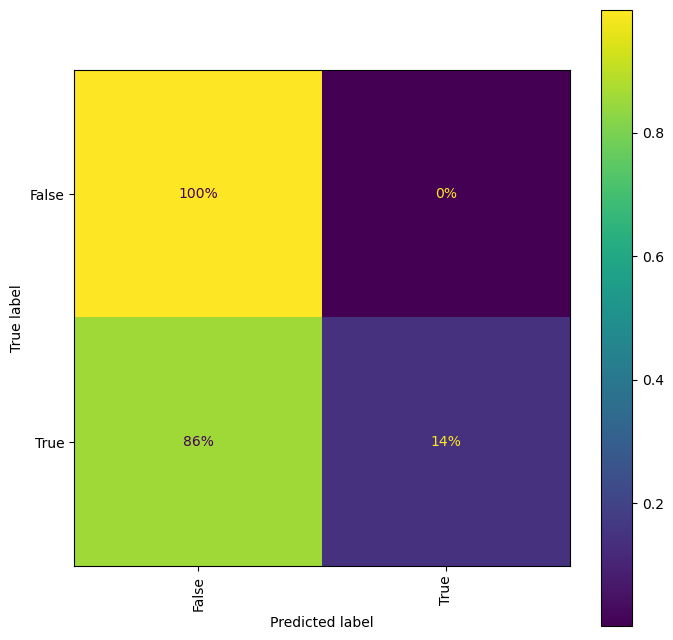

In [10]:
# Train the best model for further analysis (RFC)

# Prepare training data for the plots
train_data = pd.concat([gn_data, fp2_data, vdm_data])
test_data = fp1_data

X_train = train_data.drop(['annotation_id', 'path', 'parrot', 'start_time', 'end_time', 'site'], axis=1)
y_train = train_data['parrot']

X_test = test_data.drop(['annotation_id', 'path', 'parrot', 'start_time', 'end_time', 'site'], axis=1)
y_test = test_data['parrot']

# Apply PCA
n_components = 0.95  # This means PCA will retain 95% of the variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state = 42)
# train the random forest model on the train data
rf_model.fit(X_train_pca, y_train)

# using the test data to test the rf_model which was trained
rf_y_pred = rf_model.predict(X_test_pca)
rf_y_pred_train = rf_model.predict(X_train_pca)
rf_y_test_prob = rf_model.predict_proba(X_test_pca)[:, 1]

# plot the confusion matrix
# will compute the confusion matrix again, but normalize each row
cm_rf = confusion_matrix(y_true=y_test, y_pred=rf_y_pred, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))

# Evaluate the classifier
print("Precision on test set:", precision_score(y_test, rf_y_pred))
print("Classification Report:\n", classification_report(y_test, rf_y_pred))
print("Precision on train set:", precision_score(y_train, rf_y_pred_train))
print("Training Classification Report:\n", classification_report(y_train, rf_y_pred_train))

# plot the confusion matrix using the ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm_rf, display_labels=rf_model.classes_).plot(
    xticks_rotation="vertical",
    values_format=".0%",
    ax=ax,
);


Precision on test set: 0.9404761904761905
Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.99      0.95       830
        True       0.94      0.47      0.63       168

    accuracy                           0.91       998
   macro avg       0.92      0.73      0.79       998
weighted avg       0.91      0.91      0.89       998

Precision on train set: 0.9414634146341463
Training Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.99      0.97      2475
        True       0.94      0.76      0.84       511

    accuracy                           0.95      2986
   macro avg       0.95      0.87      0.90      2986
weighted avg       0.95      0.95      0.95      2986



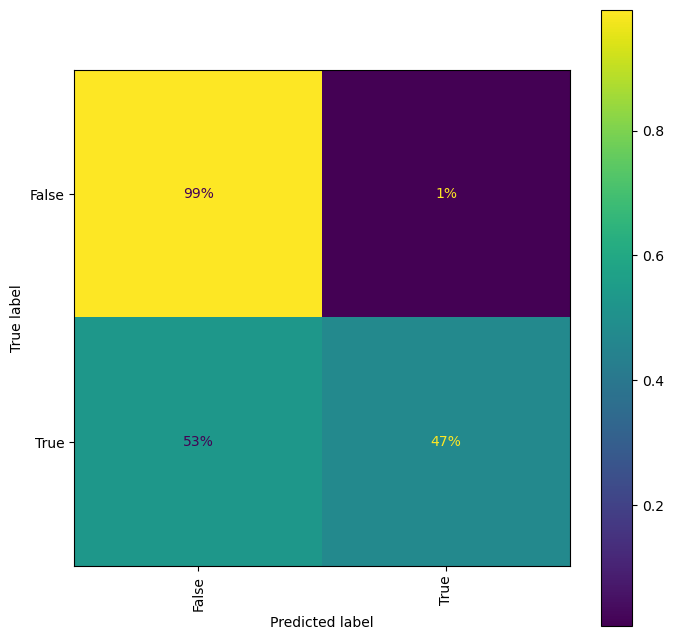

In [12]:
#Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state = 42)
# train the random forest model on the train data
lr_model.fit(X_train_pca, y_train)

# using the test data to test the rf_model which was trained
lr_y_pred = lr_model.predict(X_test_pca)
lr_y_pred_train = lr_model.predict(X_train_pca)
lr_y_test_prob = lr_model.predict_proba(X_test_pca)[:, 1]

# plot the confusion matrix
# will compute the confusion matrix again, but normalize each row
cm_lr = confusion_matrix(y_true=y_test, y_pred=lr_y_pred, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))

# Evaluate the classifier
print("Precision on test set:", precision_score(y_test, lr_y_pred))
print("Classification Report:\n", classification_report(y_test, lr_y_pred))
print("Precision on train set:", precision_score(y_train, lr_y_pred_train))
print("Training Classification Report:\n", classification_report(y_train, lr_y_pred_train))

# plot the confusion matrix using the ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm_lr, display_labels=lr_model.classes_).plot(
    xticks_rotation="vertical",
    values_format=".0%",
    ax=ax,
);

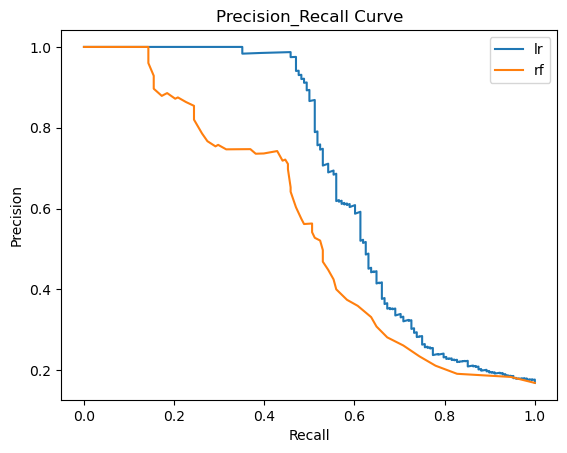

In [14]:
# Further Analyse and Compare the RF and LR model
## Precision-Recall Curve was selected as they are better at dealing with imbalance data where positive data are in minor
#LR PRC
precision, recall, thresholds = precision_recall_curve(y_test, lr_y_test_prob)

# Adding on the RFC
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf_y_test_prob)

plt.plot(recall, precision, label = "lr")
plt.plot(recall_rf, precision_rf, label = "rf")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision_Recall Curve")
plt.savefig('precision_recall_curve.png', dpi=300)

In [16]:
# Summarise the Precision Recall Curve comparison using AP (average precision)
ap_rf = average_precision_score(y_test, rf_y_test_prob)
ap_lr = average_precision_score(y_test, lr_y_test_prob)
print("Average precision of random forest:{:.3f}".format(ap_rf))
print("Average precision of logistic regression:{:.3f}".format(ap_lr))

Average precision of random forest:0.546
Average precision of logistic regression:0.677


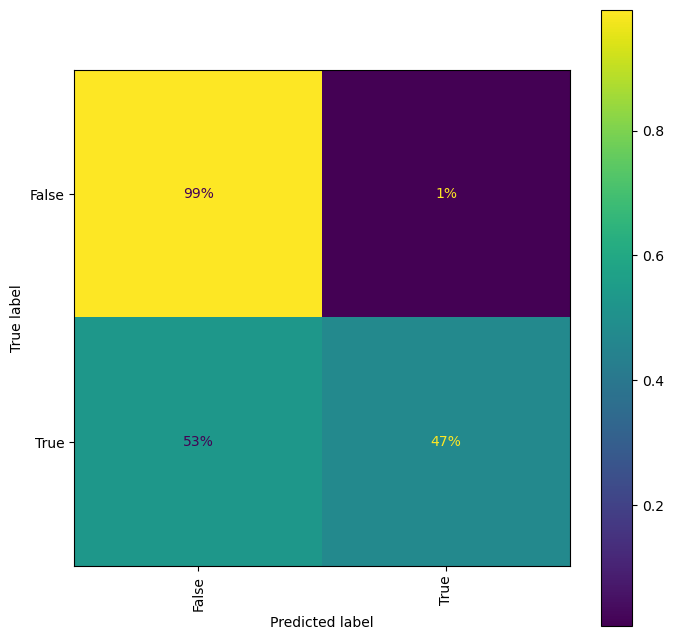

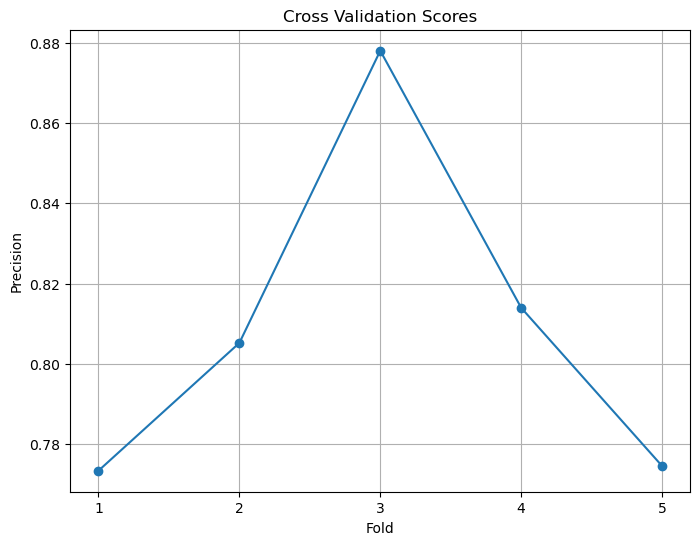

In [128]:
# save the lr plots
# Plot confusion matrix
cm_lr = confusion_matrix(y_true=y_test, y_pred=lr_y_pred, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm_lr, display_labels=lr_model.classes_).plot(
    xticks_rotation='vertical',
    values_format='.0%',
    ax=ax,
);
plt.savefig('lr_confusion_matrix.png', dpi=300)

# Plot cross-validation scores
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 5 fold cross validation
cross_val_scores = cross_val_score(lr_model, X_train_pca, y_train, cv=kf, scoring = 'precision')

# define the value for x，which is the folds of cross validation
x_values = range(1, 6)

plt.figure(figsize=(8, 6))
plt.plot(x_values, cross_val_scores, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.title('Cross Validation Scores')
plt.xticks(x_values)
plt.grid(True)
plt.savefig('lr_cv_scores.png', dpi=300)


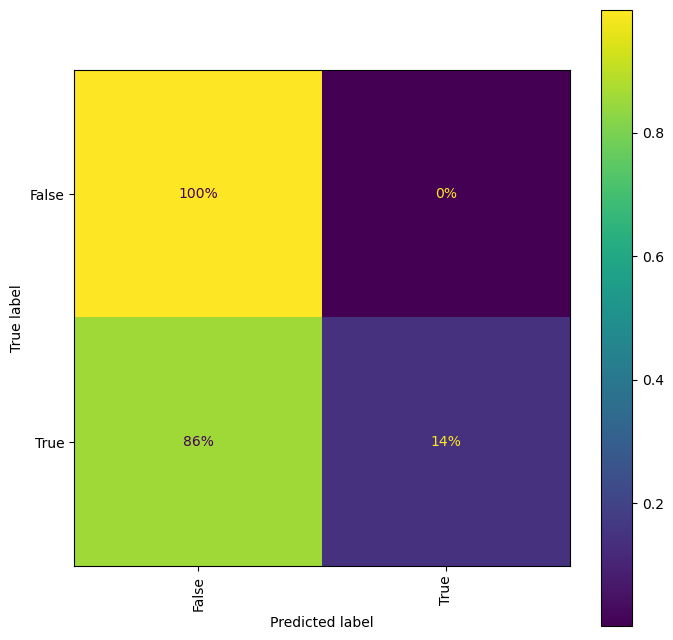

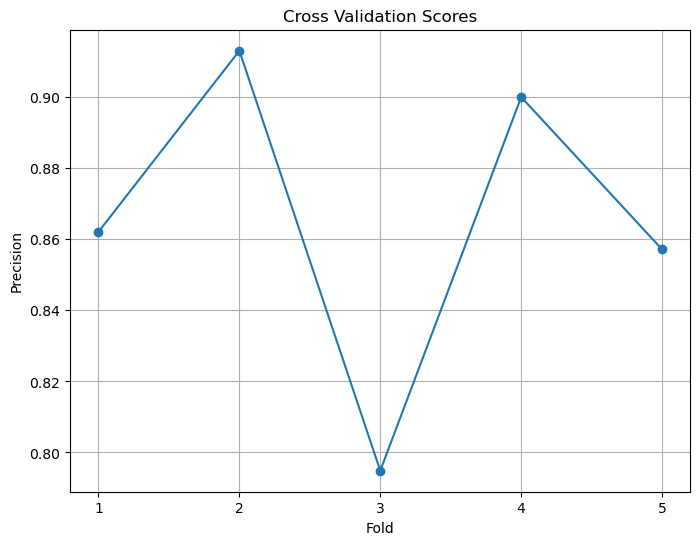

In [130]:
# save th RF plots
# Plot confusion matrix
cm_rf = confusion_matrix(y_true=y_test, y_pred=rf_y_pred, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm_rf, display_labels=lr_model.classes_).plot(
    xticks_rotation='vertical',
    values_format='.0%',
    ax=ax,
);
plt.savefig('rf_confusion_matrix.png', dpi=300)

# Plot cross-validation scores
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 5 fold cross validation
cross_val_scores = cross_val_score(rf_model, X_train_pca, y_train, cv=kf, scoring = 'precision')

# define the value for x，which is the folds of cross validation
x_values = range(1, 6)

plt.figure(figsize=(8, 6))
plt.plot(x_values, cross_val_scores, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.title('Cross Validation Scores')
plt.xticks(x_values)
plt.grid(True)
plt.savefig('rf_cv_scores.png', dpi=300)
